In [1]:
import json

notebook_file = "/home/ryounis/Documents/Zurich/PEACHLab/datascience-visualisation/data/datasets/Natural Language Processing with Disaster Tweets/classified_notebooks.json"
with open(notebook_file, 'r') as file:
    data = json.load(file)
LABELS = data["metadata"]["labels"]

In [2]:
import os
import sys; sys.path.insert(0, "../")
from Clusterers.clusterer import ClassCluster
from tqdm import tqdm

with open('../../../secrets/api_key.txt', 'r') as f: api_key = f'{f.read()}'

os.environ["OPENAI_API_KEY"] = api_key
clusterer = ClassCluster()
grouped_cells = {label: [] for label in LABELS}
for notebook in tqdm(data["notebooks"]):
    for cell in notebook["cells"]:
        cell["embedding"] = clusterer.embed_cell(cell["code"], cell["desc"])
        grouped_cells[cell["class"]].append(cell)
        
for label, cells in grouped_cells.items():
    print(f'{label}: {len(cells)}')

/home/ryounis/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 28/28 [00:28<00:00,  1.02s/it]

Data_Transform: 246
Data_Extraction: 55
Visualization: 82
Model_Train: 120
Model_Evaluation: 88
Imports_and_Environment: 80
Data_Export: 38
Exploratory_Data_Analysis: 173


In [3]:
cells = grouped_cells["Data_Transform"]

In [4]:
import numpy as np

embeddings = np.array([cell["embedding"] for cell in cells])

In [7]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=30, n_iter=3000)
reduced_embeddings = tsne.fit_transform(embeddings)
reduced_embeddings

/home/ryounis/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


array([[  1.4911424 , -20.977583  ],
       [  4.1030197 ,  -8.340393  ],
       [  4.1923532 ,  -8.065796  ],
       [  3.9924166 ,  -8.613281  ],
       [  3.0819228 ,   7.3527956 ],
       [ -6.8498898 ,   9.318042  ],
       [ -8.514273  ,   4.8970323 ],
       [  3.0791552 ,   7.351713  ],
       [  2.7196898 ,   3.7462842 ],
       [ -3.08045   ,  15.636194  ],
       [ -8.1040535 ,   7.3929768 ],
       [ -7.6331873 ,   6.8954935 ],
       [ -8.570385  ,  -1.3460537 ],
       [  0.40983674,  -5.7024317 ],
       [  9.1918955 ,   4.253837  ],
       [ -0.5927596 ,  16.993883  ],
       [ -0.7142469 ,  16.78827   ],
       [ -5.877225  ,   4.5820756 ],
       [ -4.0901    ,  -3.8603642 ],
       [ -0.53378254,  14.493711  ],
       [  8.059087  ,   8.669608  ],
       [  8.057986  ,   8.684082  ],
       [  4.608428  ,   1.8113874 ],
       [  4.398058  ,  11.601454  ],
       [  4.7468767 ,   1.7341857 ],
       [ -2.359604  ,  -5.2552366 ],
       [ -5.0885825 ,  -3.835769  ],
 

In [6]:
from sklearn.decomposition import PCA

# Create a PCA object
pca = PCA(n_components=0.9)

# Fit the PCA model to the embeddings
reduced_embeddings = pca.fit_transform(embeddings)

# Print the shape of the reduced embeddings
print(reduced_embeddings.shape)

(246, 65)


In [8]:
from sklearn.cluster import HDBSCAN
import numpy as np
import sklearn.metrics.pairwise as pairwise
 
# reduced_embeddings = pairwise.cosine_distances(reduced_embeddings)
clusterer = HDBSCAN(
    min_cluster_size=10,
    min_samples=2,
    cluster_selection_epsilon=0,
    max_cluster_size=None,
    alpha=1,
    # metric="precomputed"
)

clusterer.fit(reduced_embeddings)
labels = clusterer.labels_
for i, n in  enumerate(np.bincount([label+1 for label in labels])):
    print(f"Cluster {i-1}: {n}")

Cluster -1: 51
Cluster 0: 13
Cluster 1: 21
Cluster 2: 47
Cluster 3: 36
Cluster 4: 78


In [9]:
cluster_indices = np.where(labels == -1)[0]
cluster_points = reduced_embeddings[cluster_indices]
cluster_points = pairwise.cosine_distances(cluster_points)
clusterer.fit(cluster_points)
outlier_labels = clusterer.labels_
for i, n in  enumerate(np.bincount([label+1 for label in outlier_labels])):
    print(f"Cluster {i-1}: {n}")

Cluster -1: 5
Cluster 0: 31
Cluster 1: 15


In [10]:
max_cluster = max(labels)+1
for i, idx in enumerate(cluster_indices):
    if outlier_labels[i] != -1:
        labels[idx] = max_cluster + outlier_labels[i]

for i, n in  enumerate(np.bincount([label+1 for label in labels])):
    print(f"Cluster {i-1}: {n}")

Cluster -1: 5
Cluster 0: 13
Cluster 1: 21
Cluster 2: 47
Cluster 3: 36
Cluster 4: 78
Cluster 5: 31
Cluster 6: 15


In [11]:
from Clusterers.title_generator import TitleGenerator

title_generator = TitleGenerator()
descs = [cell["desc"] for cell in cells]
titles = title_generator.generate_titles_from_descs(labels, descs)
titles

100%|██████████| 8/8 [00:06<00:00,  1.32it/s]


{'0': 'Natural Language Processing with spaCy and NLTK',
 '1': 'Text Preprocessing with NLP Methods in Python',
 '2': 'Data Preprocessing with NLTK and Pandas',
 '3': 'Data Preparation and TensorFlow Models',
 '4': 'Text Preprocessing and Vectorization Techniques',
 '5': 'Data Processing with Pandas, NLTK, TfidfVectorizer',
 '6': 'Text Preprocessing with TensorFlow and CountVectorizer',
 '-1': 'Data Preprocessing and Encoding with Dictionaries'}

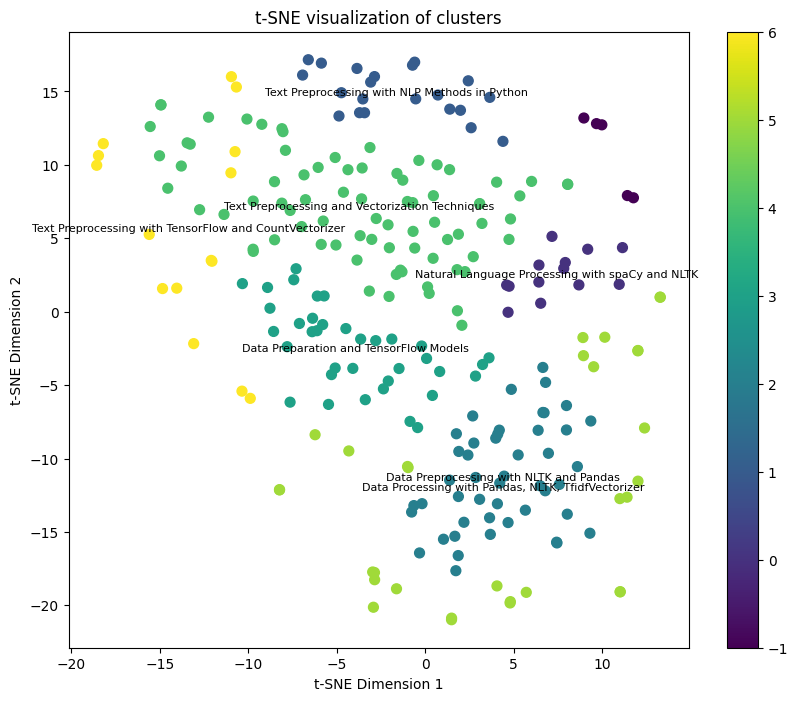

In [12]:
plt.figure(figsize=(10, 8))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels, cmap='viridis', s=50)
plt.colorbar()
plt.title('t-SNE visualization of clusters')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')

# Add titles for each cluster
for i, label in enumerate(np.unique(labels)):
    if label != -1:
        plt.text(reduced_embeddings[labels == label, 0].mean(), reduced_embeddings[labels == label, 1].mean(), titles[str(label)], fontsize=8, ha='center', va='center')

plt.show()

In [19]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

sil_score = silhouette_score(reduced_embeddings, labels)
ch_index = calinski_harabasz_score(reduced_embeddings, labels)
db_index = davies_bouldin_score(reduced_embeddings, labels)
print(f"Silhouette Score:           {sil_score} (how similar a point is to its own cluster (cohesion) compared to other clusters (separation))")
print(f"Calinski-Harabasz Index:    {ch_index} (ratio of the sum of between-cluster dispersion and within-cluster dispersion)")
print(f"Davies-Bouldin Index:       {db_index} (average similarity ratio of each cluster with the cluster that is most similar to it)")

Silhouette Score:           0.24592193961143494 (how similar a point is to its own cluster (cohesion) compared to other clusters (separation))
Calinski-Harabasz Index:    103.57980725673966 (ratio of the sum of between-cluster dispersion and within-cluster dispersion)
Davies-Bouldin Index:       1.5289414279040352 (average similarity ratio of each cluster with the cluster that is most similar to it)


In [23]:
import pandas as pd
from IPython.display import display, HTML

# Create a list to store the data
data = []

# Iterate over the cells
for i, cell in enumerate(cells):
    # Get the code, description, cluster, and title
    code = cell["code"]
    desc = cell["desc"]
    cluster = labels[i]
    title = titles[str(labels[i])]

    # Append the data to the list
    data.append([code, desc, cluster, title])

# Create the dataframe
df = pd.DataFrame(data, columns=["Code", "Description", "Cluster", "Title"])
# Set the maximum number of rows to display
pd.set_option('display.max_rows', None)

# Display the dataframe
display(HTML(df.to_html()))
df

,Code,Description,Cluster,Title
0,"train_df = train_df.drop(columns=[""id"", ""keyword"", ""location""])","This code snippet drops the ""id"", ""keyword"", and ""location"" columns from the training DataFrame to focus on the relevant data for the analysis.",9,DataFrame Preprocessing and Text Vectorization
1,"def remove_URL(text):\n url = re.compile(r'https?://\S+|www\.\S+')\n return url.sub(r'',text)\n\ntrain_df[""text""] = train_df[""text""].apply(remove_URL)\ntest_df[""text""] = test_df[""text""].apply(remove_URL)","This code snippet defines a function to remove URLs from text and applies this function to the ""text"" column in both the training and test DataFrames to clean the data.",7,Text Preprocessing and Data Splitting Techniques
2,"def remove_html(text):\n html=re.compile(r'<.*?>')\n return html.sub(r'',text)\n\ntrain_df[""text""] = train_df[""text""].apply(remove_html)\ntest_df[""text""] = test_df[""text""].apply(remove_html)","This code snippet defines a function to remove HTML tags from text and applies this function to the ""text"" column in both the training and test DataFrames to further clean the data.",7,Text Preprocessing and Data Splitting Techniques
3,"def remove_emoji(text):\n emoji_pattern = re.compile(""[""\n u""\U0001F600-\U0001F64F"" # emoticons\n u""\U0001F300-\U0001F5FF"" # symbols & pictographs\n u""\U0001F680-\U0001F6FF"" # transport & map symbols\n u""\U0001F1E0-\U0001F1FF"" # flags (iOS)\n u""\U00002702-\U000027B0""\n u""\U000024C2-\U0001F251""\n ""]+"", flags=re.UNICODE)\n return emoji_pattern.sub(r'', text)\n\ntrain_df[""text""] = train_df[""text""].apply(remove_emoji)\ntest_df[""text""] = test_df[""text""].apply(remove_emoji)","This code snippet defines a function to remove emojis from text and applies this function to the ""text"" column in both the training and test DataFrames to clean the data further.",2,Text Preprocessing and Tokenization for NLP
4,"train_tensor = tokenizer(list(train_df[""text""]), padding=""max_length"",\n truncation=True, max_length=30,\n return_tensors=""pt"")[""input_ids""]","This code snippet tokenizes the text data from the training DataFrame, padding to a maximum length, truncating where necessary, and converting the tokens into tensors suitable for model input.",2,Text Preprocessing and Tokenization for NLP
5,"class TweetDataset:\n def __init__(self, tensors, targ, ids):\n self.text = tensors[ids, :]\n self.targ = targ[ids].reset_index(drop=True)\n \n def __len__(self):\n return len(self.text)\n \n def __getitem__(self, idx):\n \n t = self.text[idx]\n y = self.targ[idx]\n \n return t, tensor(y)","This code snippet defines a custom dataset class, `TweetDataset`, which takes tokenized text tensors, target labels, and indices to create a dataset that can be utilized in model training and evaluation processes.",2,Text Preprocessing and Tokenization for NLP
6,"train_ids, valid_ids = RandomSplitter()(train_df)\n\n\ntarget = train_df[""target""]\n\ntrain_ds = TweetDataset(train_tensor, target, train_ids)\nvalid_ds = TweetDataset(train_tensor, target, valid_ids)\n\ntrain_dl = DataLoader(train_ds, bs=64)\nvalid_dl = DataLoader(valid_ds, bs=512)\ndls = DataLoaders(train_dl, valid_dl).to(""cuda"")","This code snippet splits the training DataFrame into training and validation sets, creates corresponding datasets using the custom `TweetDataset` class, wraps these datasets in DataLoader objects with specified batch sizes, and then combines them into a DataLoaders object, moving them to the GPU for training.",8,Text Data Preprocessing and Vectorization Techniques
7,"test_tensor = tokenizer(list(test_df[""text""]),\n padding=""max_length"",\n truncation=True,\n max_length=30,\n return_tensors=""pt"")[""input_ids""]","This code snippet tokenizes the text data from the test DataFrame, padding to a maximum length, truncating where necessary, and converting the tokens into tensors suitable for model inference.",2,Text Preprocessing and Tokenization for NLP
8,"class TestDS:\n def __in

,Code,Description,Cluster,Title
0,"train_df = train_df.drop(columns=[""id"", ""keywo...","This code snippet drops the ""id"", ""keyword"", a...",9,DataFrame Preprocessing and Text Vectorization
1,def remove_URL(text):\n url = re.compile(r'...,This code snippet defines a function to remove...,7,Text Preprocessing and Data Splitting Techniques
2,def remove_html(text):\n html=re.compile(r'...,This code snippet defines a function to remove...,7,Text Preprocessing and Data Splitting Techniques
3,def remove_emoji(text):\n emoji_pattern = r...,This code snippet defines a function to remove...,2,Text Preprocessing and Tokenization for NLP
4,"train_tensor = tokenizer(list(train_df[""text""]...",This code snippet tokenizes the text data from...,2,Text Preprocessing and Tokenization for NLP
5,"class TweetDataset:\n def __init__(self, te...",This code snippet defines a custom dataset cla...,2,Text Preprocessing and Tokenization for NLP
6,"train_ids, valid_ids = RandomSplitter()(train_...",This code snippet splits the training DataFram...,8,Text Data Preprocessing and Vectorization Tech...
7,"test_tensor = tokenizer(list(test_df[""text""]),...",This code snippet tokenizes the text data from...,2,Text Preprocessing and Tokenization for NLP
8,"class TestDS:\n def __init__(self, tensors)...",This code snippet defines a custom dataset cla...,10,Text Data Preprocessing and Analysis Functions
9,stop_words=nltk.corpus.stopwords.words('englis...,This code processes the text data in the 'text...,1,Text Data Cleaning and Preprocessing Functions
